# Laboratorio 3

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from PIL import Image

## 1. Analisis Exploratorio

In [2]:
data = pd.read_csv('./digit-recognizer/train.csv')

data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data.shape

(42000, 785)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
label_counts = {}
for x in data["label"]:
    if x not in label_counts:
        label_counts[x] = 1
    else:
        label_counts[x] += 1

print(label_counts)

{1: 4684, 0: 4132, 4: 4072, 7: 4401, 3: 4351, 5: 3795, 8: 4063, 9: 4188, 2: 4177, 6: 4137}


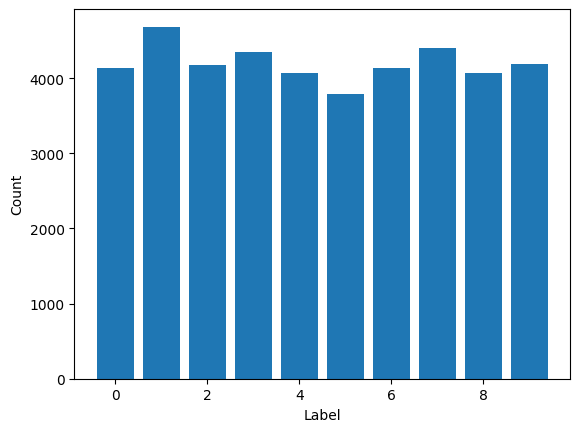

In [6]:
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

Al observar la grafica del conteo de labels se puede observar que el dataset se encuentra balanceado por lo que no es necesario realizar un balanceo de datos y se puede continuar con la clasificacion. 

## 2. Modelo de Redes Neuronales Simples

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mejores hiperparámetros: {'hidden_layer_sizes': (50,)}
Accuracy: 94.43%


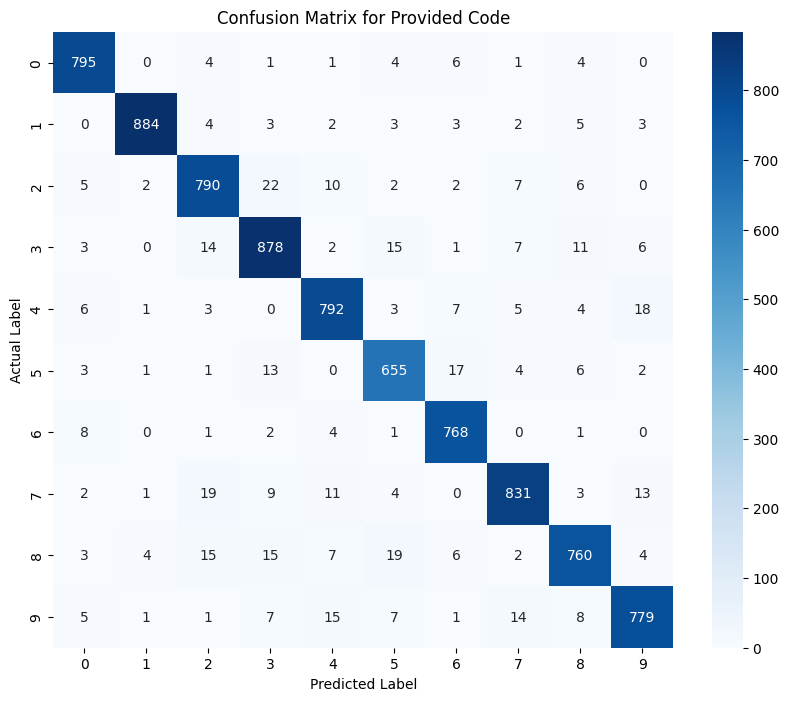

In [8]:
y = data["label"]
X = data.drop("label", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_grid_1 = {"hidden_layer_sizes":[(15,), (25,), (50,)]}

# Creación de la red neuronal

# Aquí estamos creando una red neuronal con una capa oculta de 5 neuronas
mlp = MLPClassifier(random_state=42)

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid_1, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros:", grid_search.best_params_)

best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

conf_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", 
            xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Provided Code')
plt.show()

El mejor modelo de red neuronal simple es el que contiene 50 neuronas en la capa oculta, presentando una precisión de 0.94. Este modelo presenta varios errores en la clasificación de los datos. El error que más resalta es la clasificación erronea de los números 2 marcandolos como 3. Este error se presenta 22 veces en la predicción del modelo. Por otro lado, el modelo es bastante bueno clasificando 1 como 1, clasificando 884 datos correctamente. 

## 3. Modelo de Deep Learning

In [9]:
from keras.utils import to_categorical

# Separar las etiquetas y las imágenes
X_train_normalize = X_train.values / 255.0
X_test_normalize = X_test.values / 255.0
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test) 

# Cambiar la forma de los datos de las imágenes
images = X_train_normalize.reshape(-1, 28, 28, 1)
images_test = X_test_normalize.reshape(-1, 28, 28, 1)

# Codificar las etiquetas en formato one-hot

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))  # 10 clases de salida

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

def create_model(optimizer='adam', filters=32):
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

param_dist = {
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=2)
random_search_results = random_search.fit(images, y_train_one_hot)


C:\Users\aleja\AppData\Local\Temp\ipykernel_13848\2926487328.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


Epoch 1/10
420/420 [==============================] - 7s 14ms/step - loss: 0.2757 - accuracy: 0.9209
Epoch 2/10
420/420 [==============================] - 6s 14ms/step - loss: 0.0874 - accuracy: 0.9746
Epoch 3/10
420/420 [==============================] - 6s 14ms/step - loss: 0.0547 - accuracy: 0.9839
Epoch 4/10
420/420 [==============================] - 6s 15ms/step - loss: 0.0376 - accuracy: 0.9882
Epoch 5/10
420/420 [==============================] - 6s 14ms/step - loss: 0.0270 - accuracy: 0.9917
Epoch 6/10
420/420 [==============================] - 6s 14ms/step - loss: 0.0184 - accuracy: 0.9950
Epoch 7/10
420/420 [==============================] - 6s 14ms/step - loss: 0.0135 - accuracy: 0.9959
Epoch 8/10
420/420 [==============================] - 6s 15ms/step - loss: 0.0101 - accuracy: 0.9972
Epoch 9/10
420/420 [==============================] - 7s 16ms/step - loss: 0.0071 - accuracy: 0.9982
Epoch 10/10
105/105 [==============================] - 1s 5ms/step - loss: 0.0708 - accurac

In [13]:
# Usando los hiperparámetros obtenidos del proceso de afinación
best_params = random_search_results.best_params_

model = create_model()
history = model.fit(images, y_train_one_hot, batch_size=best_params['batch_size'], epochs=best_params['epochs'], validation_split=0.2)

Epoch 1/20
840/840 [==============================] - 10s 11ms/step - loss: 0.2302 - accuracy: 0.9302 - val_loss: 0.1059 - val_accuracy: 0.9714
Epoch 2/20
840/840 [==============================] - 9s 11ms/step - loss: 0.0755 - accuracy: 0.9767 - val_loss: 0.0746 - val_accuracy: 0.9792
Epoch 3/20
840/840 [==============================] - 9s 11ms/step - loss: 0.0448 - accuracy: 0.9861 - val_loss: 0.0722 - val_accuracy: 0.9808
Epoch 4/20
840/840 [==============================] - 9s 11ms/step - loss: 0.0288 - accuracy: 0.9911 - val_loss: 0.0675 - val_accuracy: 0.9793
Epoch 5/20
840/840 [==============================] - 9s 11ms/step - loss: 0.0191 - accuracy: 0.9937 - val_loss: 0.0660 - val_accuracy: 0.9842
Epoch 6/20
840/840 [==============================] - 9s 11ms/step - loss: 0.0151 - accuracy: 0.9949 - val_loss: 0.0731 - val_accuracy: 0.9820
Epoch 7/20
840/840 [==============================] - 9s 11ms/step - loss: 0.0107 - accuracy: 0.9969 - val_loss: 0.0806 - val_accuracy: 0.981

In [15]:
test_loss, test_accuracy = model.evaluate(images_test, y_test_one_hot)
print(f"Accuracy on test data: {test_accuracy * 100:.2f}%")

263/263 [==============================] - 1s 3ms/step - loss: 0.0847 - accuracy: 0.9833
Accuracy on test data: 98.33%


263/263 [==============================] - 1s 3ms/step


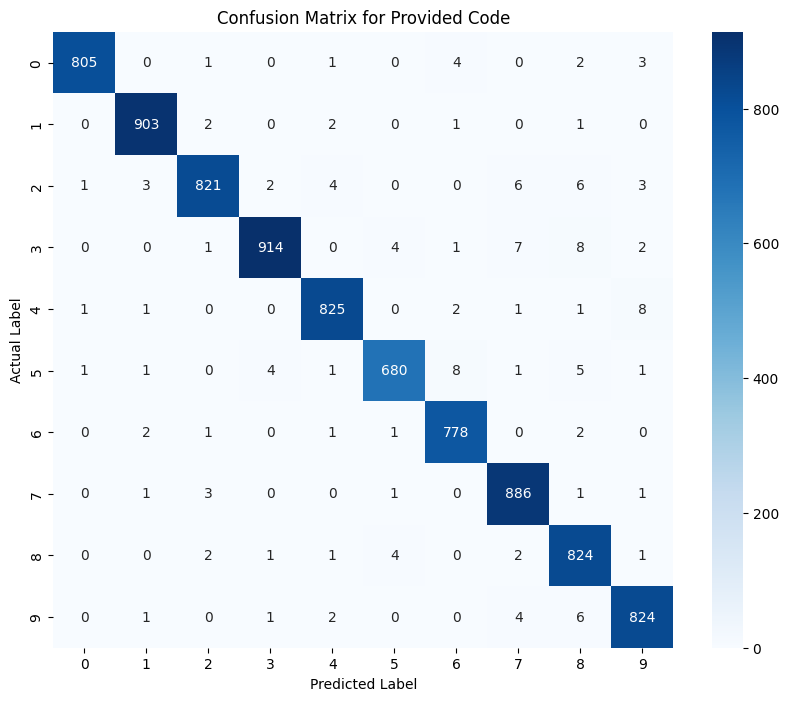

In [18]:
y_pred_one_hot = model.predict(images_test)
y_pred = np.argmax(y_pred_one_hot, axis=1)

conf_mat_2 = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_2, annot=True, fmt="d", cmap="Blues", 
            xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Provided Code')
plt.show()

Este modelo de Deep Learning presentó una precisión de 0.98 al evarluar su rendimiento. Este modelo se confunde con mayor frecuencia con  los pares de numeros 9 y 4 y 5 y 8. Estos errores son bastante comunes hasta en las personas. Sin embargo estos errores son son poco frecuentes con un total de 8 ocurrencias para cada tipo. Por otro lado, el modelo es bastante bueno para oredecir las los numeros 3 y 1 con mas de 900 ocurrencias para cada uno.

## 4. Modelo Cualquiera

##### Random forest

El otro modelo que se utilizara es el de random forest. Este modelo se seleccionó debido a la capacidad de hacer varias predicciones debiles y combinarlas para obtener una predicción más precisa. 

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mejores hiperparámetros: {'n_estimators': 200}
Accuracy: 96.36%


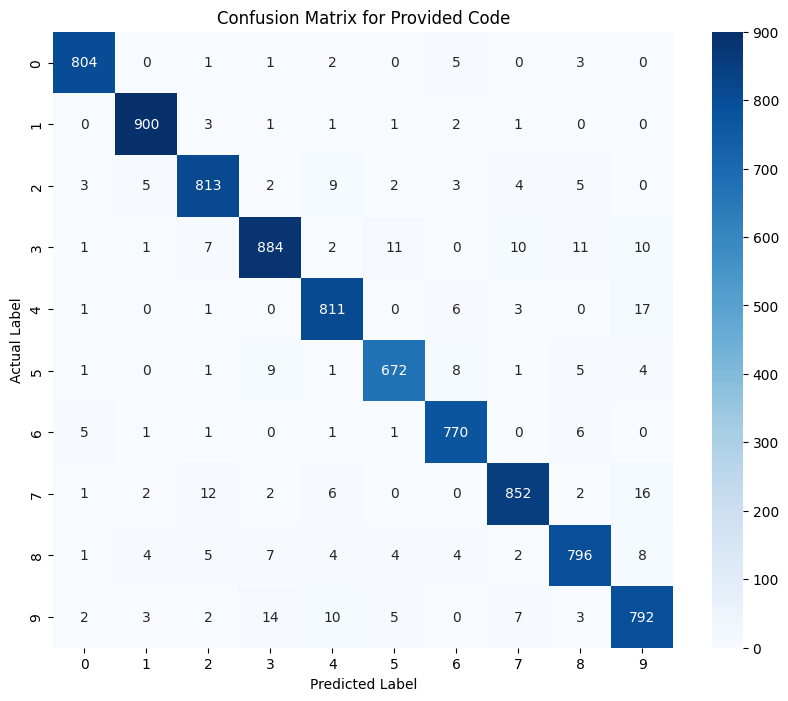

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Executing the provided code

# Cargando el conjunto de datos
param_grid_2 = {
    'n_estimators': [50, 100, 200]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_2, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Calculando y mostrando la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Compute the confusion matrix for the provided code's predictions
conf_mat_3 = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_3, annot=True, fmt="d", cmap="Blues", 
            xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Provided Code')
plt.show()



El mejor modelo de Random Forest tuvo una precisión de 0.96. Este modelo se confundió más con el label 4, marcadondolos como 9. Esto es seguido por el label 7, marcandolos como 9. Por otro lado, el modelo se confundió menos con el label 1 con 900 datos clasificados correctamente. Seguido por la clasificación del label 3.

El mejor modelo fue el de Deep Learning, con un accuracy de 0.98, seguido por el de Random Forest con un accuracy de 0.96 y por ultimo el de red neuronal simple con accuracy de 0.94. Por lo que para la siguiente parte se utilizará este modelo. 

## 5. Prueba del mejor modelo

In [20]:
images = ["./2.png", "./3.png", "./5.png", "./6.png", "./7.png"]
for imagen in images:
    image = Image.open(imagen).convert('L').resize((28, 28))
    image = np.array(image)
    invertedImage = 255 - image
    new_image = invertedImage.reshape(1, 28, 28, 1)
    y_pred = model.predict(new_image)
    print("Clase predicha: ", np.argmax(y_pred))

1/1 [==============================] - 0s 71ms/step
Clase predicha:  2
1/1 [==============================] - 0s 20ms/step
Clase predicha:  3
1/1 [==============================] - 0s 19ms/step
Clase predicha:  3
1/1 [==============================] - 0s 19ms/step
Clase predicha:  6
1/1 [==============================] - 0s 19ms/step
Clase predicha:  7


Al usar el modelo de Deep Learning para predecir los numeros hechos a mano pudo detectar correctamente 4 de los 5 numeros, el numero que no pudo detectar fue el 5, el cual fue confundido con el numero 3. Esto se debe a que el numero 5 tiene una forma muy similar al numero 3, por lo que el modelo no pudo diferenciarlos correctamente. Sin embargo el modelo pudo detectar correctamente los numeros 2, 3, 6 y 7.